In [202]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.vis_model import *
from src.models.train_model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Experiment with lag

In [216]:
data = Dataset('Chiang Mai')
data.load_()
data.monitor = data.pollutant = 'PM2.5'
# build the first dataset 
data.feature_no_fire()
data.fire_dict = {'w_speed': 7, 'shift': -5, 'roll': 44}
# use default fire feature
data.merge_fire()


data no fire has shape (77747, 14)
use default fire feature


['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000']

In [217]:
print('Step 1 Get a reasonable RF model')
data.split_data(split_ratio=[0.3, 0.25, 0.25, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
print(xtrn.shape)

Step 1 Get a reasonable RF model
(23324, 17)


In [4]:
%%time
model = do_rf_search(xtrn,ytrn, x_tree=False)
score_dict = cal_scores(yval, model.predict(xval), header_str ='val_')
print('optimize 1 score', score_dict) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
{'n_estimators': 120, 'min_samples_split': 50, 'min_samples_leaf': 12, 'max_features': 2, 'max_depth': None, 'bootstrap': True} 0.12148704705450666
optimize 1 score {'val_r2_score': 0.5107975772057206, 'val_mean_squared_error': 615.8945686775909, 'val_mean_absolute_error': 14.907642748269327}
Wall time: 6min 52s


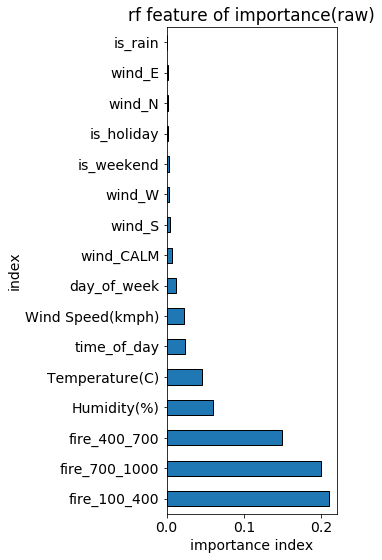

In [5]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(raw)')


In [6]:
# optimize 1 drop unuse cols 
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]

for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)
to_drop.reverse()

model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

old cols length 17
drop is_rain
drop wind_E
drop wind_N
drop is_weekend
drop wind_W
drop day_of_week
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_S', 'is_holiday', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2_score after dropping columns 0.5354552887695351


In [218]:
data.x_cols_org = data.x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_S', 'is_holiday', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000']

data.data_org = data.data[data.x_cols_org + [data.monitor]]

data.fire_dict = {'w_speed': 7, 'shift': -5, 'roll': 44}

data.split_data(split_ratio=[0.3, 0.25, 0.25, 0.2])
model = RandomForestRegressor(**{'n_estimators': 120, 'min_samples_split': 50, 'min_samples_leaf': 12, 'max_features': 2, 'max_depth': None, 'bootstrap': True} )

In [5]:
%%time
data.fire_dict, gp_result = sk_op_fire(data, model, trn_index=data.split_list[0], val_index=data.split_list[1])
print(data.fire_dict)

skop_ fire use x_cols ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_S', 'is_holiday', 'time_of_day', 'fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000']
old score 14.767829432042104 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter using skopt optimizer. This will take about 20 mins
mean_absolute_error for the best fire parameters 14.318928093836577
{'w_speed': 7, 'shift': -5, 'roll': 44}
Wall time: 15min 10s


In [219]:
data.split_data(split_ratio=[0.45, 0.25, 0.3])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)
model.fit(xtrn,ytrn)
cal_scores(yval, model.predict(xval))

{'test_r2_score': 0.6892129758262073,
 'test_mean_squared_error': 154.51890304753374,
 'test_mean_absolute_error': 8.739730065150068}

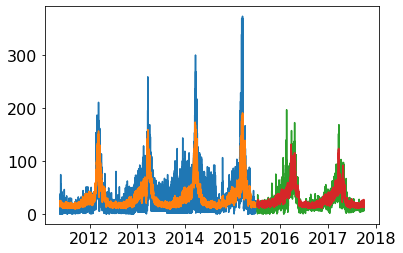

In [220]:
plt.plot(data.split_list[0], ytrn)
plt.plot(data.split_list[0], model.predict(xtrn))

plt.plot(data.split_list[1], yval)
plt.plot(data.split_list[1], model.predict(xval))

In [248]:
# Add lag
#data.build_lag(lag_range=[1,5,10,20,50,100,200])
score = 154
best_lag = 0
score_df = []
for max_n in np.arange(12,36,1):
    for step in np.arange(1,13,2):
        data.build_lag(lag_range=np.arange(1,max_n,step),roll=True)
    
        data.x_cols = data.data.columns
    
        data.split_data(split_ratio=[0.45, 0.25, 0.3])
        xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
        xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)
        print(xtrn.shape)
        model.fit(xtrn,ytrn)
        result_dict = cal_scores(yval, model.predict(xval))
        result_dict['step'] = step
        score_df.append(pd.DataFrame(result_dict, index=[max_n]))
     
score_df = pd.concat(score_df).sort_values(['test_mean_squared_error'])
score_df.sort_values('test_mean_squared_error')

(34981, 133)
(34981, 56)
(34981, 45)
(34982, 34)
(34981, 34)
(34985, 23)
(34980, 144)
(34981, 56)
(34981, 45)
(34982, 34)
(34981, 34)
(34980, 34)
(34980, 155)
(34980, 67)
(34981, 45)
(34982, 34)
(34981, 34)
(34980, 34)
(34979, 166)
(34980, 67)
(34981, 45)
(34982, 34)
(34981, 34)
(34980, 34)
(34979, 177)
(34980, 67)
(34981, 45)
(34979, 45)
(34981, 34)
(34980, 34)
(34978, 188)
(34978, 78)
(34978, 56)
(34979, 45)
(34981, 34)
(34980, 34)
(34978, 199)
(34978, 78)
(34978, 56)
(34979, 45)
(34981, 34)
(34980, 34)
(34978, 210)
(34978, 78)
(34978, 56)
(34979, 45)
(34981, 34)
(34980, 34)
(34977, 221)
(34977, 89)
(34978, 56)
(34979, 45)
(34977, 45)
(34980, 34)
(34977, 232)
(34977, 89)
(34978, 56)
(34979, 45)
(34977, 45)
(34980, 34)
(34976, 243)
(34977, 89)
(34976, 67)
(34979, 45)
(34977, 45)
(34980, 34)
(34976, 254)
(34976, 100)
(34976, 67)
(34976, 56)
(34977, 45)
(34980, 34)
(34975, 265)
(34976, 100)
(34976, 67)
(34976, 56)
(34977, 45)
(34975, 45)
(34975, 276)
(34976, 100)
(34976, 67)
(34976, 56)

,test_r2_score,test_mean_squared_error,test_mean_absolute_error,step
12,0.905082,47.192001,4.316788,11
14,0.876727,61.287102,5.128404,9
12,0.876498,61.401039,5.198639,9
16,0.876425,61.437906,5.082981,11
14,0.875265,62.015300,5.110443,7
...,...,...,...,...
25,0.754517,122.047966,7.813560,1
28,0.753880,122.356072,7.822415,1
35,0.752689,122.961562,7.894733,1
34,0.752369,123.120628,7.918511,1


In [256]:
%%time
lag_dict, gp_result = op_lag(data, model, split_ratio=[0.45, 0.25, 0.3])

new mean squared error 43.58435051767538 using {'max_n': 12, 'step': 25}
Wall time: 6min 28s


In [257]:
data.build_lag(lag_range=np.arange(1,lag_dict['n_max'],lag_dict['step']),roll=True)
data.x_cols = data.data.columns
    
data.split_data(split_ratio=[0.45, 0.25, 0.3])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)
print(xtrn.shape)
model.fit(xtrn,ytrn)
result_dict = cal_scores(yval, model.predict(xval))

result_dict

(34985, 23)


{'test_r2_score': 0.9133531453995838,
 'test_mean_squared_error': 43.07958789775131,
 'test_mean_absolute_error': 4.112504672174814}

In [259]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()

# optimize 1 drop unuse cols 
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]

for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)
to_drop.reverse()
model, new_x_cols = reduce_cols(dataset=data,x_cols=data.x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
data.x_cols = new_x_cols

old cols length 23
drop is_holiday
drop wind_S
drop wind_CALM
drop wind_S_lag_1
drop wind_CALM_lag_1
drop time_of_day_lag_1
drop time_of_day
drop Wind Speed(kmph)_lag_1
drop Temperature(C)_lag_1
drop Humidity(%)_lag_1
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'fire_0_100',
       'fire_100_400', 'fire_400_700', 'fire_700_1000', 'PM2.5',
       'is_holiday_lag_1', 'fire_0_100_lag_1', 'fire_100_400_lag_1',
       'fire_400_700_lag_1', 'fire_700_1000_lag_1'],
      dtype='object')
r2_score after dropping columns 0.9527129113839794


In [261]:
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)

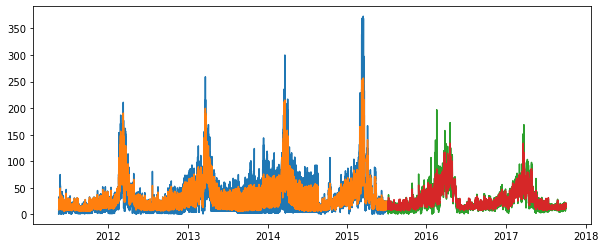

In [262]:
plt.figure(figsize=(10,4))
plt.plot(data.split_list[0], ytrn)
plt.plot(data.split_list[0], model.predict(xtrn))

plt.plot(data.split_list[1], yval)
plt.plot(data.split_list[1], model.predict(xval))

#plt.xlim([data.split_list[1][100:].min(), data.split_list[1][:2000].max()])

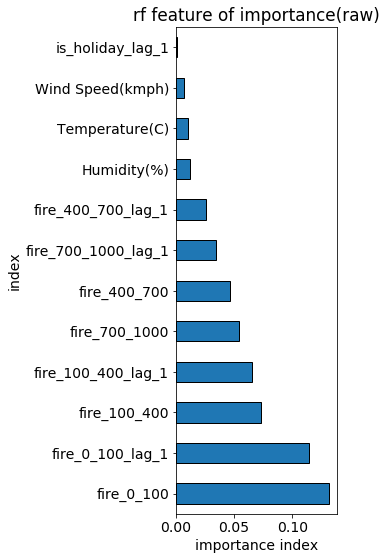

In [263]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp, title='rf feature of importance(raw)')

## Senario

In [181]:
col_to_reduce = data.data.columns[data.data.columns.str.contains('fire_0_100')]
data.data[col_to_reduce] *=0.1 

In [177]:
col_to_reduce = data.data.columns[data.data.columns.str.contains('fire_100_400')]
data.data[col_to_reduce] *=0.1 

In [182]:
# Build a senario
#data.split_data(split_ratio=[0.35, 0.25, 0.20, 0.2])
xtrn_s , ytrn_s, x_cols = data.get_data_matrix(use_index=data.split_list[0], x_cols=data.x_cols)
xval_s, yval_s, _ = data.get_data_matrix(use_index=data.split_list[1], x_cols=data.x_cols)

In [183]:
ytrn_s_pred = model.predict(xtrn_s)
yval_s_pred = model.predict(xval_s)

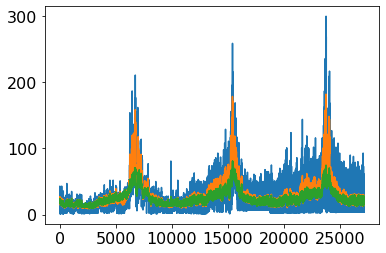

In [184]:
plt.plot(ytrn_s)
plt.plot(model.predict(xtrn))
plt.plot(ytrn_s_pred)

In [186]:
trn_df_s = pd.DataFrame(ytrn, index=data.split_list[0], columns=['PM2.5'])
trn_df_s['pred'] = model.predict(xtrn_s)
trn_df_s['shift'] = trn_df_s['PM2.5'].shift(1) + 2*np.random.normal(size=len(trn_df_s))
trn_df_s = trn_df_s.round().dropna()


val_df_s = pd.DataFrame(yval, index=data.split_list[1], columns=['PM2.5'])
val_df_s['pred'] = model.predict(xval_s)
val_df_s['shift'] = val_df_s['PM2.5'].shift(1) + 2*np.random.normal(size=len(val_df_s))
val_df_s = val_df_s.round().dropna()

In [187]:
ytrn_ln_s = trn_df_s['PM2.5'].values
xtrn_ln_s = trn_df_s[['pred','shift']].values

yval_ln_s = val_df_s['PM2.5'].values
xval_ln_s = val_df_s[['pred','shift']].values

In [210]:
yln_iter_pred = []
for i, value in enumerate(trn_df_s['pred']):
    if i == 0:
        arr = np.array([value, int_value]).reshape(1,-1)
    else: 
        arr = np.array([value, prev]).reshape(1,-1)
        
    prev = regr.predict(arr)
    yln_iter_pred.append(prev)
    
    
yval_iter_pred = []
for i, value in enumerate(val_df_s['pred']):
    if i == 0:
        arr = np.array([value, int_value]).reshape(1,-1)
    else: 
        arr = np.array([value, prev]).reshape(1,-1)
        
    prev = regr.predict(arr)
    yval_iter_pred.append(prev)

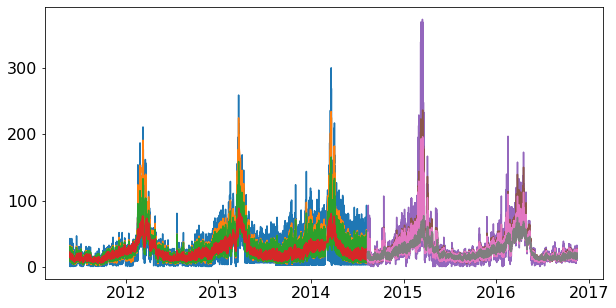

In [213]:
plt.figure(figsize=(10,5))
plt.plot(trn_df.index[1:], ytrn_ln)
plt.plot(trn_df.index[1:], regr.predict(xtrn_ln))
plt.plot(trn_df_s.index, regr.predict(xtrn_ln_s) )
plt.plot(trn_df.index[1:], yln_iter_pred)

plt.plot(val_df.index, yval_ln)
plt.plot(val_df.index, regr.predict(xval_ln))
plt.plot(val_df_s.index, regr.predict(xval_ln_s) )
plt.plot(val_df.index, yval_iter_pred)

# Training with Lag 

## Stage 1

data no fire has shape (77747, 14)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True} 0.5030494316951373
optimize 1 score {'val_r2_score': 0.6744124428305336, 'val_mean_squared_error': 161.8775182570654, 'val_mean_absolute_error': 8.842797468980773}
=================optimize 2: remove unncessary columns=================
old cols length 18
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']
score after dropping columns {'r2_score': 0.6744124428305336, 'mean_squared_error': 161.8775182570654, 'mean_absolute_error': 8.842797468980773}
================= optimization 3: find the best fire feature ===========

KeyboardInterrupt: 

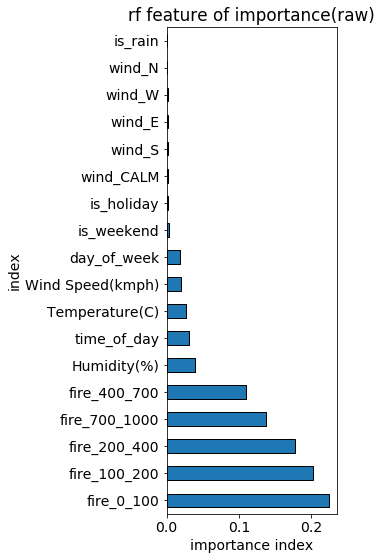

In [226]:
%%time 
data, rf_model , poll_meta = train_city_s1(city='Chiang Mai', pollutant='PM2.5', build=False)

In [ ]:
%%time 

fire_dict = {'w_speed': 7, 'shift': -5, 'roll': 44}
x_cols_org = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']
model = RandomForestRegressor(**{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True})
data, rf_model , poll_meta = train_city_s1(city='Chiang Mai', pollutant='PM2.5', build=False,
                                          model=model, fire_dict=fire_dict, x_cols_org=x_cols_org)

data no fire has shape (77747, 14)
================= optimization 4: improve model performance by adding lag columns =================
model parameters {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[ 1  7 13 19 25 31]
(126,)
(34972, 126)
[ 1 19]
(54,)
(34977, 54)
[ 1 19]
(54,)
(34977, 54)
[ 1  6 11 16]
(90,)
(34978, 90)
[ 1  4  7 10 13 16 19 22 25 28 31 34]
(234,)
(34970, 234)
[1 9]
(54,)
(34982, 54)


# Stage 2

In [171]:
def iter_predict(ln_model, x:np.array):
    """Loop through all prediction from rf_model. Use previous prediction to predict the next value.
    
    Args: 
        ln_model: linear model for prediction 
        x: 2D numpy array x[:,0] is the lag columns, x[:, 1] is the prediction columns
    
    Returns: list
        yiter_pred: a list of predicted value 
        
    """
    # use the previous value to predict the next value 
    yiter_pred = []

    for i, values in enumerate(x[:,1]):
        if i == 0:
            arr = np.array([x[0,0], values]).reshape(1,-1)
        else:
            arr = np.array([prev, values]).reshape(1, -1)        
    
        prev = ln_model.predict(arr)    
        yiter_pred.append(prev)
    
    return yiter_pred

In [213]:
data, model, fire_cols = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7,0.3])

data no fire has shape (77747, 14)

 fire_columns ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols_org ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000']

 x_cols ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_N', 'wind_W', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700', 'fire_700_1000', 'Temperature(C)_lag_1', 'Humidity(%)_lag_1', 'Wind Speed(kmph)_lag_1', 'wind_N_lag_1', 'wind_W_lag_1', 'is_holiday_lag_1', 'is_weekend_lag_1', 'day_of_week_lag_1', 'time_of_day_lag_1', 'fire_100_200_lag_1', 'fire_200_400_lag_1', 'fire_400_700_lag_1', 'fire_700_1000_lag_1']
model performance {'test_r2_score': 0.6641845910943396, 'test_mean_squared_error': 262.54691473209186, 'test_mean_a

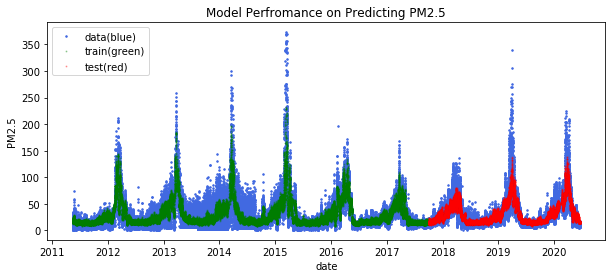

In [214]:
plot_model_perf(dataset=data, model=rf_model, split_list=[0.7, 0.3], xlim=[], to_save=False)

In [114]:
data.split_data(split_ratio=[0.45, 0.25, 0.3])

pred_df = []

for idx in data.split_list:  
    x, y, _ = data.get_data_matrix(use_index=idx,x_cols=data.x_cols)
    pred_df.append(pd.DataFrame(model.predict(x), index=idx))
    
pred_df = pd.concat(pred_df,sort=True)
pred_df.columns = ['pred']

In [115]:
# add lag_columns
ln_data_df = data.data[[data.monitor]]
ln_data_df = add_lags(ln_data_df, data.monitor, num_lags=[1])
print('data shape before merge with prediction', ln_data_df.shape)
ln_data_df = pd.concat([ln_data_df, pred_df ], axis=1).dropna()
print('data shape after merge with prediction', ln_data_df.shape)

data shape before merge with prediction (77744, 2)
data shape after merge with prediction (77744, 3)


In [118]:
# init linear data object
ln_data = Dataset(city_name=data.city_name)
ln_data.monitor = ln_data.pollutant = data.monitor
ln_data.data = ln_data_df


In [176]:
ln_data.split_data(split_ratio=[0.45, 0.25, 0.3])
xtrn, ytrn, ln_data.x_cols = ln_data.get_data_matrix(use_index=ln_data.split_list[0])
xval, yval, _ = ln_data.get_data_matrix(use_index=ln_data.split_list[1])

In [209]:
for ln_model in [Lasso(normalize=True,fit_intercept=False), ElasticNet(normalize=True,fit_intercept=False), Ridge(normalize=True,fit_intercept=False), LinearRegression(normalize=True,fit_intercept=False)]:
    # split the data again
    ln_data.split_data(split_ratio=[0.7, 0.3])
    xtrn, ytrn, ln_data.x_cols = ln_data.get_data_matrix(use_index=ln_data.split_list[0])
    xtest, ytest, _ = ln_data.get_data_matrix(use_index=ln_data.split_list[1])
    ln_model.fit(xtrn, ytrn)
     
    ytest_pred = iter_predict(ln_model, xtest)
    print( ln_model, cal_scores(ytest, ytest_pred))

Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) {'test_r2_score': 0.666734997565916, 'test_mean_squared_error': 260.55295813371174, 'test_mean_absolute_error': 10.536507594106858}
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=False, l1_ratio=0.5,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) {'test_r2_score': 0.6668975187977799, 'test_mean_squared_error': 260.4258959237215, 'test_mean_absolute_error': 10.539649904042053}
Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001) {'test_r2_score': 0.6670663082613697, 'test_mean_squared_error': 260.29393309018394, 'test_mean_absolute_error': 10.548165390596282}
LinearRegression(copy_X=True, fit_intercept=Fal

In [120]:
ln_model = do_ln_search(xtrn, ytrn)

{'l1_ratio': 0.0, 'alpha': 1} 0.839726573511341


In [196]:
# split the data again
ln_data.split_data(split_ratio=[0.7, 0.3])
xtrn, ytrn, ln_data.x_cols = ln_data.get_data_matrix(use_index=ln_data.split_list[0])
xtest, ytest, _ = ln_data.get_data_matrix(use_index=ln_data.split_list[1])
ln_model.fit(xtrn, ytrn)
cal_scores(ytest, ln_model.predict(xtest))

{'test_r2_score': 0.9512268110316029,
 'test_mean_squared_error': 38.13181273315333,
 'test_mean_absolute_error': 3.87251062057577}

In [197]:
ytest_pred = iter_predict(ln_model, xtest)
cal_scores(ytest, ytest_pred)

{'test_r2_score': 0.6751755673205472,
 'test_mean_squared_error': 253.95395913339496,
 'test_mean_absolute_error': 10.06676735567656}

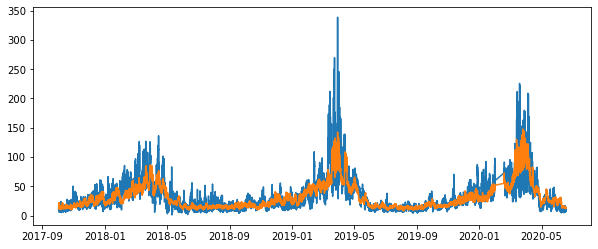

In [198]:
plt.figure(figsize=(10,4))
plt.plot(ln_data.split_list[1], ytest)
plt.plot(ln_data.split_list[1], ytest_pred)


In [138]:
# iterative prediction
ln_data.split_data(split_ratio=[1])
x, y, _ = ln_data.get_data_matrix(use_index=ln_data.split_list[0])

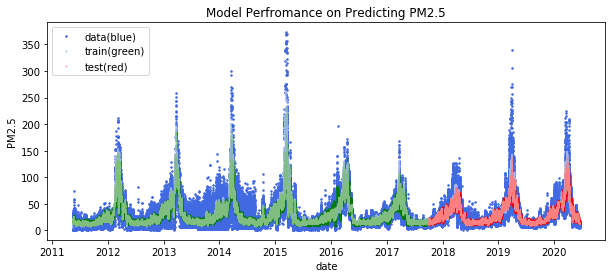

In [212]:
plot_model_perf(dataset=data, model=rf_model, split_list=[0.7, 0.3], xlim=[], to_save=False)


#plot_model_perf(dataset=ln_data, model=ln_model, split_list=[0.7, 0.3], xlim=[], to_save=False)
ln_data.split_data(split_ratio=[1])
plt.plot(ln_data.split_list[0], y_iter_pred, color='white',alpha=0.5 )

(736420.5416666666, 737566.8333333334)

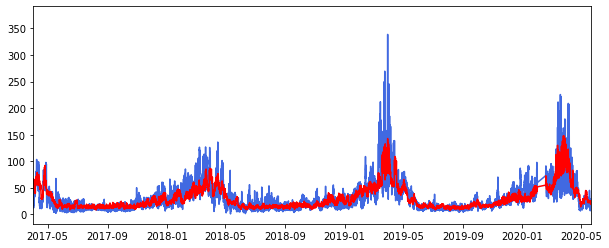

In [168]:
plt.figure(figsize=(10,4))
start_idx = 50000
stop_idx = 77100
idxs = ln_data.split_list[0] 
plt.plot(ln_data.split_list[0] , y, color='royalblue' )
plt.plot(ln_data.split_list[0], y_iter_pred, color='red',alpha=1 )

plt.xlim(idxs[start_idx], idxs[stop_idx])


In [199]:
np.sqrt(253)

15.905973720586866